# Brain Tumour Detection

Data Set : https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection/data

# Import dataset

In [548]:
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import glob
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import random
import cv2
import sys

# Reading the Images

In [6]:
# tumor = []

# path = "G:\\AIML basic projects\\my projects\\Brain\\brain_tumor_dataset\\yes\\*.jpg"

# for i in glob.iglob(path):
#     img =  cv2.imread(i)
#     img = cv2.resize(img,(128,128))
#     tumor.append(img)

# healthy = []

# path = "G:\\AIML basic projects\\my projects\\Brain\\brain_tumor_dataset\\no\\*.jpg"

# for i in glob.iglob(path):
#     img =  cv2.imread(i)
#     img = cv2.resize(img,(128,128))
#     healthy.append(img)

In [7]:
# healthy = np.array(healthy)
# tumor = np.array(tumor)
# ALL = np.concatenate((healthy,tumor))

In [8]:
# tumor.shape[0]

In [9]:
# healthy.shape

# Visualizing brain MRI images

In [11]:
# plt.imshow(healthy[0])

In [12]:
# plt.imshow(tumor[0])

In [13]:
# np.random.choice(10,5, replace = False)

In [14]:
# def plot_random(healthy, tumor, num=5):
#     healthy_images =  healthy[np.random.choice(healthy.shape[0],num, replace = False)]
#     tumor_images =  tumor[np.random.choice(tumor.shape[0],num, replace = False)] #structure : np.random.choice(end point, number of elements to be shown)

#     plt.figure(figsize = (16,9))
#     for i in range(num):
#         plt.subplot(1,num,i+1)
#         plt.title('Healthy')
#         plt.imshow(healthy_images[i])

#     plt.figure(figsize = (16,9))
#     for j in range(num):
#         plt.subplot(1,num,j+1)
#         plt.title('Tumor')
#         plt.imshow(tumor_images[j])
        

In [15]:
# plot_random(healthy, tumor, 7)

# Create Torch Dataset CLass

## Whar is Pytorch's abstract class

In [18]:
# Pytorch abstract dataset class.

# An abstract class representing a dataset.

# All other datasets should subclass it. All subclasses shoould override
# "__len__", that provides the size of the dataset, and "__getitem__",
# supporting integer indexing in range from 0 to len(self) exclusive.
class Dataset(object):

    def __getitem__(self, index):
        raise NotImplementedError

    def __len__(self):
        raise NotImplementedError

    def __add__(self, other):
        return ConcatDataset([self,other])

## Creating MRI custom dataset class

In [550]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("G:\\AIML basic projects\\my projects\\Brain\\brain_tumor_dataset\\yes\\*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("G:\\AIML basic projects\\my projects\\Brain\\brain_tumor_dataset\\yes\\*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [552]:
mri = MRI()
mri.normalize()

In [22]:
# mri[5]

# Creating a Data loader

## With out data loader

In [25]:
# index = list(range(len(mri)))
# random.shuffle(index)
# for idx in index:
#     sample = mri[idx]
#     img  = sample['image']
#     label = sample['lable']
#     plt.title(label)
#     plt.imshow(img)
#     plt.show()

## WIth data loaders

In [27]:
dataloader = DataLoader(mri,batch_size=10,shuffle=True)

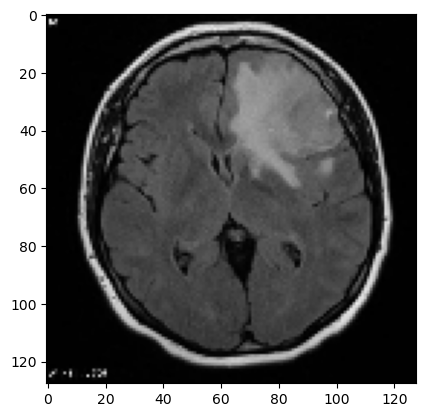

In [28]:
for sample in dataloader:
    img = sample['image'][0]
    img = img.numpy()
    plt.imshow(img)
    plt.show()
    break

# Create model

What the convolution layers do 

![](CNN_network.png)

Feature is extracted and classification is done 

![](Classification.png)

In [554]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x
            

# Look into the parameters of the model

In [36]:
model = CNN()
model.parameters

<bound method Module.parameters of CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=(2, 2), stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=(2, 2), stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Tanh()
  )
)>

In [37]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=(2, 2), stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=(2, 2), stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Tanh()
  )
)

In [38]:
model.cnn_model

Sequential(
  (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (1): Tanh()
  (2): AvgPool2d(kernel_size=(2, 2), stride=5, padding=0)
  (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (4): Tanh()
  (5): AvgPool2d(kernel_size=(2, 2), stride=5, padding=0)
)

In [39]:
model.cnn_model[0]

Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))

In [40]:
model.cnn_model[0].weight

Parameter containing:
tensor([[[[ 0.0482, -0.0242,  0.0494,  0.0087, -0.0520],
          [-0.0551,  0.1101, -0.0020, -0.0045, -0.1078],
          [-0.0823,  0.0667,  0.0039,  0.0953,  0.0361],
          [ 0.0535, -0.0184,  0.0155, -0.0482,  0.0503],
          [ 0.0599,  0.0980,  0.0249,  0.0217,  0.0531]],

         [[ 0.0355, -0.0552,  0.0272, -0.1083,  0.0493],
          [ 0.1065, -0.0606, -0.0520, -0.0324,  0.0959],
          [ 0.0739,  0.0679,  0.1154, -0.0005,  0.0989],
          [-0.0786,  0.1085, -0.1149, -0.0882, -0.0845],
          [ 0.1078, -0.0788,  0.0219,  0.1029, -0.0283]],

         [[-0.0676, -0.0341,  0.0271, -0.0750, -0.1106],
          [-0.0845, -0.0903, -0.0517,  0.0236, -0.0025],
          [ 0.0262, -0.0999, -0.0128,  0.1051, -0.0209],
          [-0.0841,  0.1005, -0.0647,  0.0479, -0.1079],
          [-0.0435,  0.0314,  0.0387,  0.0514, -0.0565]]],


        [[[-0.0895, -0.0150, -0.0875, -0.0449, -0.0152],
          [ 0.0605, -0.1016,  0.0168,  0.0989,  0.0383],
 

In [41]:
model.cnn_model[0].weight.shape

torch.Size([6, 3, 5, 5])

In [42]:
model.cnn_model[0].weight[0][0]

tensor([[ 0.0482, -0.0242,  0.0494,  0.0087, -0.0520],
        [-0.0551,  0.1101, -0.0020, -0.0045, -0.1078],
        [-0.0823,  0.0667,  0.0039,  0.0953,  0.0361],
        [ 0.0535, -0.0184,  0.0155, -0.0482,  0.0503],
        [ 0.0599,  0.0980,  0.0249,  0.0217,  0.0531]],
       grad_fn=<SelectBackward0>)

# Looking at the linear layer

In [44]:
model.fc_model

Sequential(
  (0): Linear(in_features=256, out_features=120, bias=True)
  (1): Tanh()
  (2): Linear(in_features=120, out_features=84, bias=True)
  (3): Tanh()
  (4): Linear(in_features=84, out_features=1, bias=True)
  (5): Tanh()
)

In [45]:
model.fc_model[0]

Linear(in_features=256, out_features=120, bias=True)

In [46]:
model.fc_model[0].weight

Parameter containing:
tensor([[-0.0458,  0.0263,  0.0001,  ..., -0.0523,  0.0362, -0.0035],
        [ 0.0213,  0.0302, -0.0574,  ...,  0.0174,  0.0605,  0.0289],
        [-0.0133, -0.0010,  0.0604,  ...,  0.0230,  0.0235,  0.0190],
        ...,
        [-0.0491,  0.0582, -0.0443,  ..., -0.0529, -0.0153, -0.0039],
        [-0.0549,  0.0384,  0.0519,  ...,  0.0215,  0.0142, -0.0179],
        [-0.0587, -0.0027,  0.0288,  ..., -0.0201,  0.0269,  0.0490]],
       requires_grad=True)

In [47]:
model.fc_model[0].weight.shape

torch.Size([120, 256])

# Looking at x.view(x.size(0), -1)

In [49]:
x = torch.tensor([1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16])

In [50]:
x = x.reshape((2,2,2,2)) #(32,3,128,128) (number of elements, kernel size, height, width)

In [51]:
x

tensor([[[[ 1,  2],
          [ 3,  4]],

         [[ 5,  6],
          [ 7,  8]]],


        [[[ 9, 10],
          [11, 12]],

         [[13, 14],
          [15, 16]]]])

In [52]:
x.size(0)

2

In [53]:
x.view(-1)

tensor([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16])

In [54]:
x.view(x.size(0),-1)

tensor([[ 1,  2,  3,  4,  5,  6,  7,  8],
        [ 9, 10, 11, 12, 13, 14, 15, 16]])

# Evaluate a New Neural Network

In [556]:
mri_dataset = MRI()
mri_dataset.normalize()
device = torch.device('cuda:0') # Mentioning the Gpu , index value means if we have multiple gpu then it can be used or else only one 
model = CNN().to(device)

In [558]:
dataloader = DataLoader(mri_dataset, batch_size = 32, shuffle = False)

In [582]:
model.eval()
outputs = []
y_true = []


# with torch.no_grad():

for D in dataloader:

    
    image = D['image'].to(device)
    label = D['label'].to(device)

    y_hat = model(image)

    outputs.append(y_hat.cpu().detach().numpy()) # Copying the elements from gpu to cpu , then detaching it from the graph , and converting it into a numpy array
    y_true.append(label.cpu().detach().numpy())


In [566]:
outputs = np.concatenate(outputs, axis = 0).squeeze()
y_true = np.concatenate(y_true, axis = 0).squeeze()

In [568]:
outputs[0]

0.48407772

In [570]:
def threshold(scores, threshold=0.50, minimum = 0, maximum = 1.0):
    x = np.array(list(scores))
    x[x>=threshold] = maximum
    x[x<=threshold] = minimum
    return x
    

In [572]:
y_predicted = threshold(outputs)

# Checking the accuracy

In [575]:
accuracy_score(y_true, threshold(outputs))

0.5

Text(50.722222222222214, 0.5, 'Prediction')

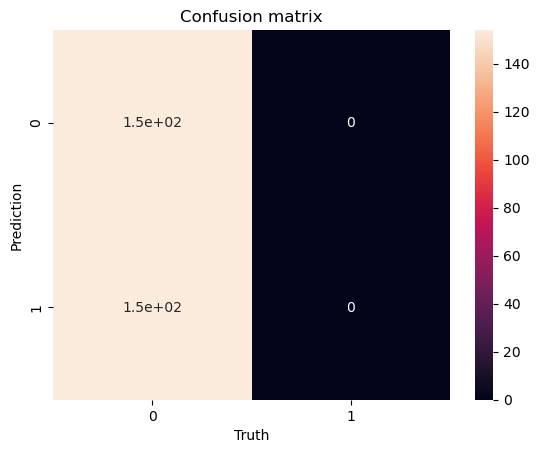

In [577]:
cm = confusion_matrix(y_true,y_predicted)
sns.heatmap(cm, annot=True)
plt.title("Confusion matrix")
plt.xlabel("Truth")
plt.ylabel("Prediction")

# Training the model

In [584]:
eta = 0.0001  #Learning rate, initial learning rate
EPOCH = 400
optimizer =  torch.optim.Adam(model.parameters(),  lr = eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle = True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [68]:
for epoch in range(1,EPOCH):
    losses = []
    for D in dataloader:

        # Resetting the optimizer
        optimizer.zero_grad()

        image = D['image'].to(device)
        lable = D['label'].to(device)
        y_hat = model(image)

        # define loss function
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()

        # Updating the values
        optimizer.step()
        losses.append(loss.item())

    if (epoch+1) % 10 == 0:
        print('Train Epoch : {}\tLoss : {:.6f}'.format(epoch+1, np.mean(losses)))
        

Train Epoch : 10	Loss : 0.645402
Train Epoch : 20	Loss : 0.617178
Train Epoch : 30	Loss : 0.580843
Train Epoch : 40	Loss : 0.566528
Train Epoch : 50	Loss : 0.552568
Train Epoch : 60	Loss : 0.531811
Train Epoch : 70	Loss : 0.521217
Train Epoch : 80	Loss : 0.516437
Train Epoch : 90	Loss : 0.503211
Train Epoch : 100	Loss : 0.494878
Train Epoch : 110	Loss : 0.483920
Train Epoch : 120	Loss : 0.477919
Train Epoch : 130	Loss : 0.466432
Train Epoch : 140	Loss : 0.457435
Train Epoch : 150	Loss : 0.448876
Train Epoch : 160	Loss : 0.444450
Train Epoch : 170	Loss : 0.440197
Train Epoch : 180	Loss : 0.434594
Train Epoch : 190	Loss : 0.432189
Train Epoch : 200	Loss : 0.428883
Train Epoch : 210	Loss : 0.412957
Train Epoch : 220	Loss : 0.417310
Train Epoch : 230	Loss : 0.408397
Train Epoch : 240	Loss : 0.403392
Train Epoch : 250	Loss : 0.403286
Train Epoch : 260	Loss : 0.399271
Train Epoch : 270	Loss : 0.402174
Train Epoch : 280	Loss : 0.395714
Train Epoch : 290	Loss : 0.395216
Train Epoch : 300	Loss 

# Evaluate the model

In [70]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle = False)
outputs = []
y_true = []

for D in dataloader:
    image = D['image'].to(device)
    label = D['lable'].to(device)

    y_hat = model(image)

    outputs.append(y_hat.cpu().detach().numpy())
    y_true.append(label.cpu().detach().numpy())

outputs = np.concatenate(outputs, axis = 0)
y_true = np.concatenate(y_true, axis = 0)

In [71]:
outputs

array([[0.73105854],
       [0.73105854],
       [0.7310557 ],
       [0.73105854],
       [0.7310572 ],
       [0.73105854],
       [0.73105854],
       [0.731039  ],
       [0.73105854],
       [0.73086715],
       [0.73098665],
       [0.73105854],
       [0.73105854],
       [0.73105854],
       [0.73105854],
       [0.73105854],
       [0.7309485 ],
       [0.7285253 ],
       [0.73105854],
       [0.73105854],
       [0.73105854],
       [0.73091   ],
       [0.73105854],
       [0.73105854],
       [0.73105854],
       [0.73105854],
       [0.7310583 ],
       [0.73105854],
       [0.7310211 ],
       [0.73105854],
       [0.73105854],
       [0.73102504],
       [0.73105854],
       [0.73105854],
       [0.73105854],
       [0.73105854],
       [0.73083186],
       [0.73105854],
       [0.73098665],
       [0.7310583 ],
       [0.7310585 ],
       [0.73105854],
       [0.73105854],
       [0.731028  ],
       [0.73105854],
       [0.73105854],
       [0.73105854],
       [0.731

In [72]:
accuracy_score(y_true,threshold(outputs))

0.9306122448979591

[]

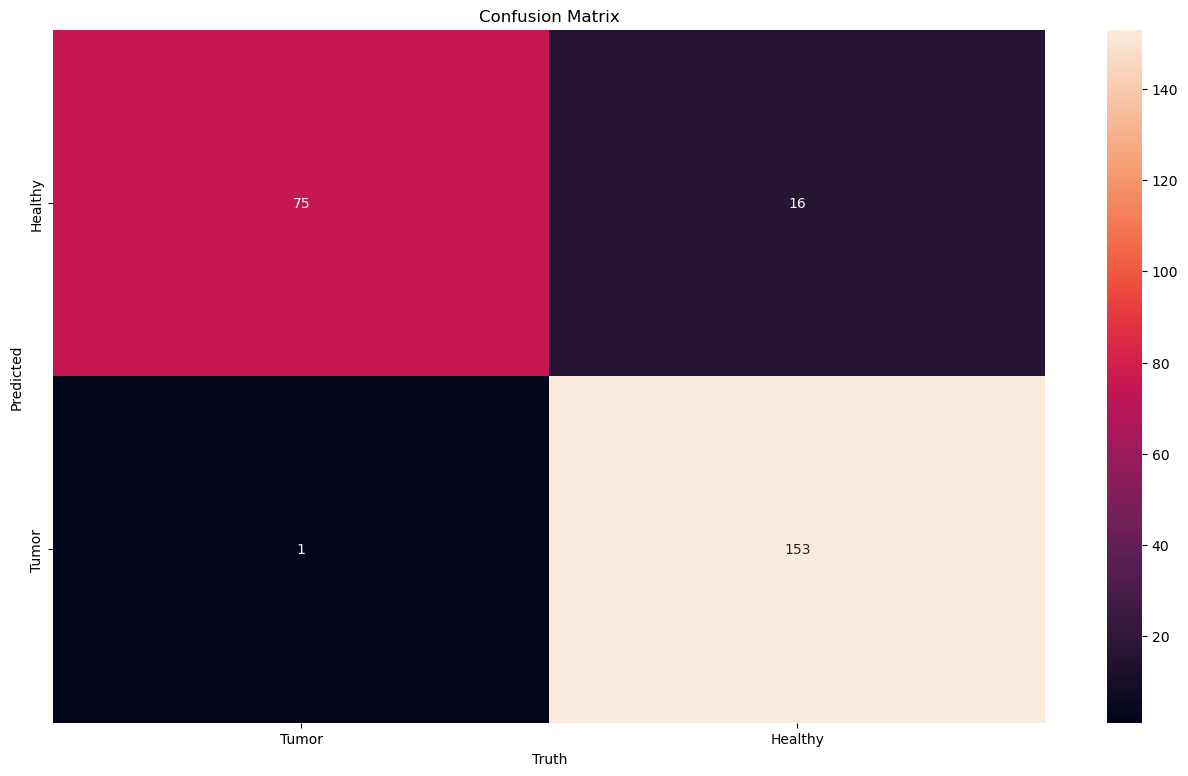

In [73]:
cm = confusion_matrix(y_true,threshold(outputs))

plt.figure(figsize=(16,9))
ax = plt.subplot()

sns.heatmap(cm, annot=True, fmt = 'g', ax = ax)
ax.set_title("Confusion Matrix")
ax.set_xlabel("Truth")
ax.set_ylabel("Predicted")
ax.xaxis.set_ticklabels(['Tumor', 'Healthy'])
ax.yaxis.set_ticklabels(['Healthy', 'Tumor'])
plt.plot()

# Visualising the feature maps of the convolutional filters

In [75]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=(2, 2), stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=(2, 2), stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
    (5): Tanh()
  )
)

In [586]:
no_of_layers = []
conv_layers = []

In [588]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [78]:
no_of_layers = 0
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer)==nn.Conv2d:
                no_of_layers +=  1
                conv_layers.append(layer)

In [79]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

(128, 128, 3)


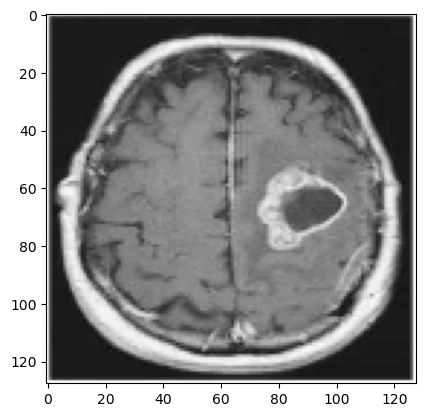

In [80]:
img  = mri_dataset[1]['image']
print(img.shape)
plt.imshow(img)


In [81]:
img = torch.from_numpy(img).to(device)

In [82]:
img = img.reshape(img.shape[2], img.shape[0], img.shape[1])
print(img.shape)

torch.Size([3, 128, 128])


In [83]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [84]:
result = [conv_layers[0](img)]


for i in range(1,len(conv_layers)):
    result.append(conv_layers[i](result[-1]))

outputs = result

In [85]:
print(outputs[0].shape) #Convo layer 1
print(outputs[1].shape) #Convo layer 2

torch.Size([1, 6, 124, 124])
torch.Size([1, 16, 120, 120])


In [86]:
outputs[0]

tensor([[[[-0.0826, -0.0871, -0.0709,  ..., -0.1014,  0.0129,  0.1423],
          [ 0.2161,  0.1200,  0.1683,  ...,  0.2019,  0.3632,  0.3678],
          [ 0.5047,  0.5481,  0.3707,  ...,  0.4895,  0.4408,  0.4293],
          ...,
          [-0.0452, -0.0753, -0.0662,  ...,  0.1286,  0.2808,  0.2175],
          [ 0.6184,  0.6882,  0.5945,  ...,  0.3949,  0.3947,  0.3639],
          [ 0.2634,  0.3162,  0.3896,  ...,  0.3628,  0.3464,  0.3847]],

         [[ 0.3717,  0.4125,  0.3032,  ...,  0.5929,  0.4886,  0.6283],
          [ 0.5376,  0.3977,  0.3462,  ...,  0.6266,  0.6783,  0.8508],
          [ 0.5873,  0.4497,  0.3572,  ...,  0.5766,  0.7110,  0.6569],
          ...,
          [ 0.6226,  0.5158,  0.4508,  ...,  0.8086,  0.8568,  0.9784],
          [ 0.6395,  0.5423,  0.4631,  ...,  0.7175,  0.7902,  0.7082],
          [ 0.5607,  0.6386,  0.5918,  ...,  0.6957,  0.6378,  0.7060]],

         [[-0.2188, -0.1531,  0.0452,  ..., -0.0647, -0.0385, -0.1822],
          [-0.0326,  0.0663, -

In [87]:
outputs[-1]

tensor([[[[ 7.1855e-01,  7.6059e-01,  6.5404e-01,  ...,  5.3746e-01,
            6.7285e-01,  8.0810e-01],
          [ 5.8333e-01,  3.8401e-01,  3.3233e-01,  ...,  5.8129e-01,
            7.0614e-01,  7.5775e-01],
          [ 4.6167e-01,  5.5605e-01,  5.4905e-01,  ...,  4.5052e-01,
            5.3372e-01,  5.8805e-01],
          ...,
          [ 4.8492e-01,  5.0314e-01,  4.1944e-01,  ...,  3.1255e-01,
            4.9621e-01,  6.6005e-01],
          [ 5.4014e-01,  3.6544e-01,  3.3065e-01,  ...,  5.0032e-01,
            6.2207e-01,  6.7281e-01],
          [ 3.8323e-01,  4.6357e-01,  4.5278e-01,  ...,  5.7949e-01,
            6.5021e-01,  7.0496e-01]],

         [[ 1.9178e-01,  1.8403e-01,  1.5662e-01,  ..., -8.7307e-02,
           -3.7860e-02, -8.9047e-02],
          [ 9.0398e-03,  2.9427e-02, -8.9753e-03,  ..., -9.1792e-02,
            4.6121e-03,  4.0087e-02],
          [ 2.4678e-01,  1.8740e-01,  6.9588e-04,  ...,  1.5244e-01,
            1.7342e-01,  1.3774e-01],
          ...,
     

Layer 1


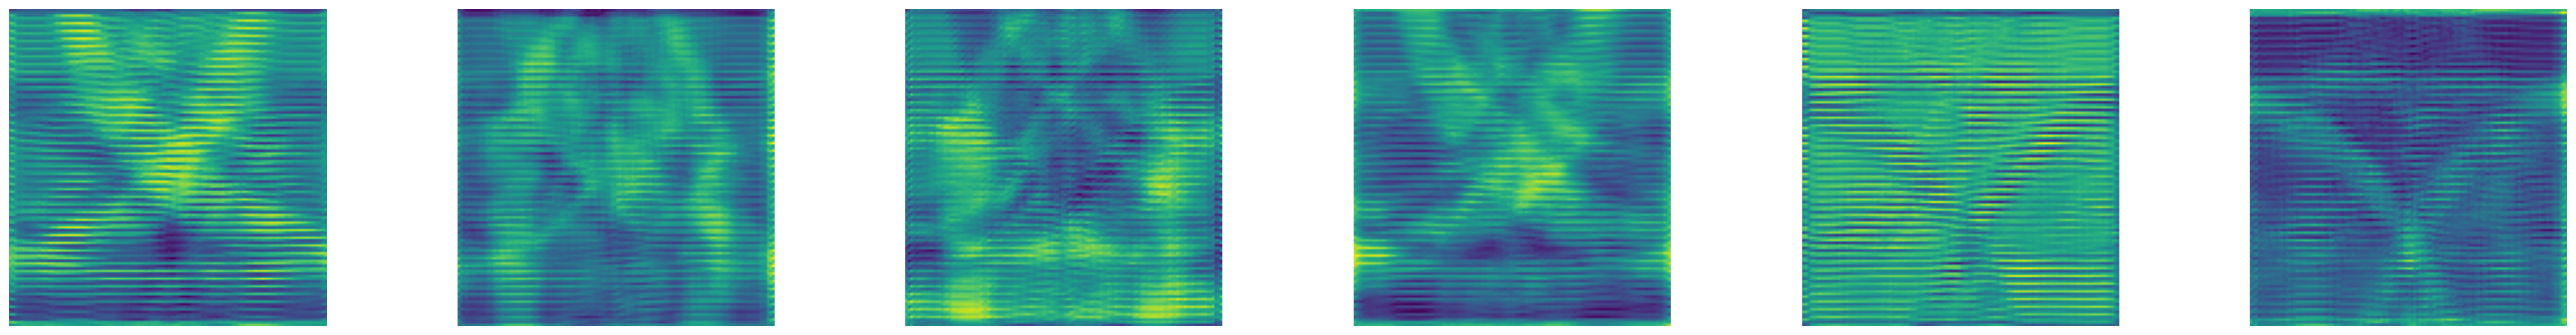

Layer 2


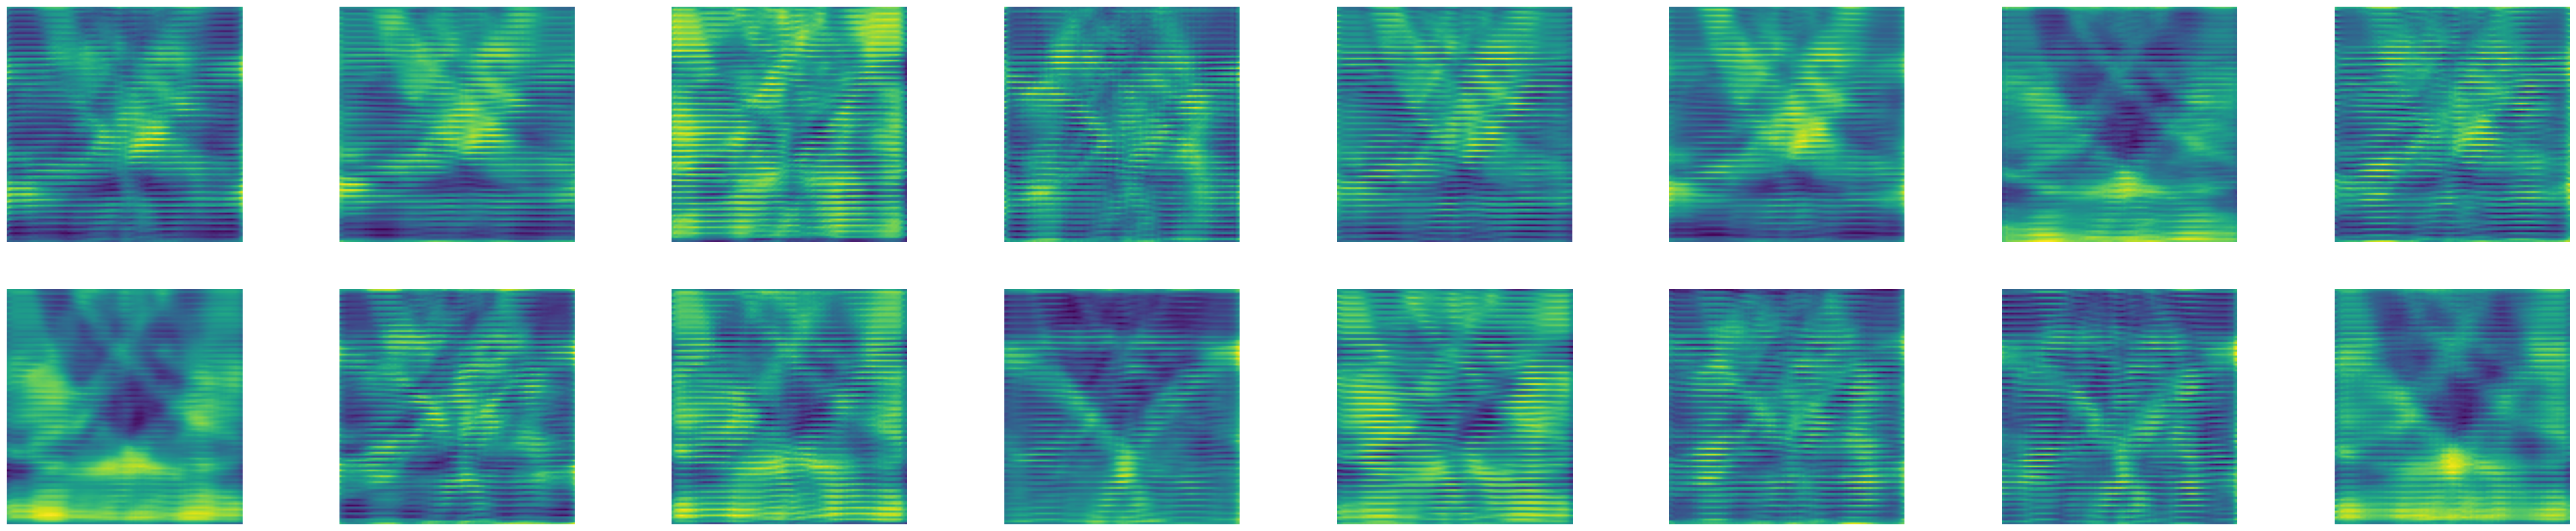

In [88]:
for num_layer in range(len(outputs)):

    plt.figure(figsize=(50,10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer", num_layer+1)

    for i,f in enumerate(layer_viz):
        # print(type(f))
        plt.subplot(2,8,i+1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis('off')
    plt.show()
    plt.close
    


# Checking for overfitting

In [590]:
class MRI(Dataset):
    def __init__(self):

        #Variable to hold training data and validation data 
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None

        # Variable to determine if we are interested in retrieving the training or validation data
        self.mode = 'train'
        
        # Getting the Tumor brain images , reshaping and storing in list
        tumor = []
        healthy = []   
        path = "G:\\AIML basic projects\\my projects\\Brain\\brain_tumor_dataset\\yes\\*.jpg"      
        for i in glob.iglob(path):
            img =  cv2.imread(i)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) 
            tumor.append(img)

        # Getting the healthy images , reshaping and storing in list  
        path = "G:\\AIML basic projects\\my projects\\Brain\\brain_tumor_dataset\\no\\*.jpg"
        for i in glob.iglob(path):
            img =  cv2.imread(i)
            img = cv2.resize(img,(128,128))
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) 
            healthy.append(img)

        # our images
        tumor  = np.array(tumor,dtype=np.float32) #Converting list to array
        healthy  = np.array(healthy,dtype=np.float32)

        # our lables
        tumor_lable = np.ones(tumor.shape[0],dtype = np.float32) #lable "1" for tumor
        healthy_lable = np.zeros(healthy.shape[0],dtype = np.float32) #Lable "0" for healthy brain

        # Concatenante     
        self.images = np.concatenate((tumor,healthy), axis=0) # Combining the tumor and healthy image
        self.lables = np.concatenate((tumor_lable,healthy_lable)) #Combining the lables together

    # Defining function that would seperate the data into training and validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val =  train_test_split(self.images, self.lables, test_size=0.2, random_state = 42)
    
    def __len__(self):
        #Use self.mode to determine weather train or val data is of interest 
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]

    def __getitem__(self, index):

        if self.mode == 'train':
 
             sample  = {
                'image' : self.X_train[index],
                'label' : self.y_train[index]
            }

        elif self.mode == 'val':
            sample  = {
                'image' : self.X_val[index],
                'label' : self.y_val[index]
            }
       
        return sample

    def normalize(self):
        self.images = self.images/255.0
        



In [592]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [594]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
tesr_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [596]:
device  = torch.device("cuda:0")
model = CNN().to(device)

In [597]:
eta = 0.0001
optimizer = torch.optim.Adam(model.parameters(), lr = eta)

In [600]:
# keep track of epoch losses 
epoch_train_loss = []
epoch_val_loss = []

In [604]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        
        loss = torch.sum(error(y_hat.squeeze(), label.squeeze()))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label.squeeze()))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))
    

Train Epoch: 10	Train Loss: 0.605278	Val Loss: 0.642886
Train Epoch: 20	Train Loss: 0.592675	Val Loss: 0.618315
Train Epoch: 30	Train Loss: 0.576042	Val Loss: 0.586877
Train Epoch: 40	Train Loss: 0.504432	Val Loss: 0.563004
Train Epoch: 50	Train Loss: 0.497994	Val Loss: 0.561527
Train Epoch: 60	Train Loss: 0.588769	Val Loss: 0.600556
Train Epoch: 70	Train Loss: 0.484049	Val Loss: 0.583462
Train Epoch: 80	Train Loss: 0.430192	Val Loss: 0.581941
Train Epoch: 90	Train Loss: 0.508196	Val Loss: 0.569434
Train Epoch: 100	Train Loss: 0.479525	Val Loss: 0.628558
Train Epoch: 110	Train Loss: 0.388322	Val Loss: 0.600091
Train Epoch: 120	Train Loss: 0.413527	Val Loss: 0.623401
Train Epoch: 130	Train Loss: 0.370160	Val Loss: 0.689622
Train Epoch: 140	Train Loss: 0.376195	Val Loss: 0.683260
Train Epoch: 150	Train Loss: 0.402950	Val Loss: 0.747536
Train Epoch: 160	Train Loss: 0.369790	Val Loss: 0.786416
Train Epoch: 170	Train Loss: 0.363036	Val Loss: 0.856912
Train Epoch: 180	Train Loss: 0.333653	Va

In [646]:
# Testing the model 

img = cv2.imread("C:\\Users\PRATHAM ASAIGOLI\\OneDrive\\Desktop\\Y23.JPG")
img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
b, g, r = cv2.split(img)
img = cv2.merge([r,g,b])
img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
img = img/255.0

beep = np.array(img)
test_img = torch.tensor(beep, dtype=torch.float32).unsqueeze(0).to(device)

with torch.no_grad():
    output = model(test_img)
    prediction = torch.sigmoid(output).item()

print(prediction)
if prediction > 0.6:
    print("Tumor detected! 🚨 Probability:", prediction)
else:
    print("No tumor detected. ✅ Probability:", prediction)

<>:3: SyntaxWarning: invalid escape sequence '\P'
<>:3: SyntaxWarning: invalid escape sequence '\P'
C:\Users\PRATHAM ASAIGOLI\AppData\Local\Temp\ipykernel_14920\798035793.py:3: SyntaxWarning: invalid escape sequence '\P'
  img = cv2.imread("C:\\Users\PRATHAM ASAIGOLI\\OneDrive\\Desktop\\Y23.JPG")


0.5000591278076172
No tumor detected. ✅ Probability: 0.5000591278076172


In [642]:
img = cv2.imread("C:\\Users\\PRATHAM ASAIGOLI\\OneDrive\\Desktop\\THERE_IS.jpg")
img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
b, g, r = cv2.split(img)
img = cv2.merge([r,g,b])
img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
img = img/255.0

beep = np.array(img)
test_img = torch.tensor(beep, dtype=torch.float32).unsqueeze(0).to(device)
with torch.no_grad():
    output = model(test_img)
    prediction = torch.sigmoid(output).item()

if prediction > 0.6:
    print("Tumor detected! 🚨 Probability:", prediction)
else:
    print("No tumor detected. ✅ Probability:", prediction)

Tumor detected! 🚨 Probability: 0.7084673643112183
